In [ ]:
# path = '/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/guided_diffusion/segmented-images/masked-images/cju0qkwl35piu0993l0dewei2.jpg'
# path = '/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/guided_diffusion/segmented-images-madison/masked-images/case2_day1_slice_0054.png'

In [64]:
import os
import numpy as np
from PIL import Image
from torchvision import io

In [65]:
# Image is in grayscale format. Load in RGB
image = io.read_image(path)#, mode=io.ImageReadMode.RGB)

In [66]:
image.shape

torch.Size([3, 529, 622])

In [18]:
image.shape

torch.Size([3, 266, 266])

In [23]:
# Base image is RGB

In [ ]:
kvasir_masked_images_path = '/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/guided_diffusion/segmented-images/masked-images'

In [25]:
x_dims = []
for file in os.listdir(kvasir_masked_images_path):
    image = io.read_image(os.path.join(kvasir_masked_images_path, file), mode=io.ImageReadMode.RGB)
    print(f"Image: {file}, Shape: {image.shape}, Dtype: {image.dtype}")
    x_dims.append(image.shape[1])  # Append the width and height dimensions

Image: cju3tvffffx5f0818t5ov22al.jpg, Shape: torch.Size([3, 530, 622]), Dtype: torch.uint8
Image: cju1b0y2e396p08558ois175d.jpg, Shape: torch.Size([3, 546, 626]), Dtype: torch.uint8
Image: cju2u73dj53oz0878486k8k4b.jpg, Shape: torch.Size([3, 529, 524]), Dtype: torch.uint8
Image: cju88v2f9oi8w0871hx9auh01.jpg, Shape: torch.Size([3, 546, 626]), Dtype: torch.uint8
Image: cju8adb60qbiu080188mxpf8d.jpg, Shape: torch.Size([3, 528, 623]), Dtype: torch.uint8
Image: cju40m0rjkpw80871z6n6yg1u.jpg, Shape: torch.Size([3, 528, 586]), Dtype: torch.uint8
Image: cju2lcyfgkf5809932fn9gucn.jpg, Shape: torch.Size([3, 530, 571]), Dtype: torch.uint8
Image: cju2tvrvm53ws0801a0jfjdxg.jpg, Shape: torch.Size([3, 531, 568]), Dtype: torch.uint8
Image: cju5wkonqlrl409877y8zvnub.jpg, Shape: torch.Size([3, 547, 627]), Dtype: torch.uint8
Image: cju8chdlqsu620755azjty1tj.jpg, Shape: torch.Size([3, 530, 622]), Dtype: torch.uint8
Image: cju7d8m3b2e210755l8fj1yph.jpg, Shape: torch.Size([3, 528, 619]), Dtype: torch.uint8

In [87]:
import torch
from torchvision.ops import masks_to_boxes
from torchvision.io import read_image, ImageReadMode

from tqdm import tqdm

def get_bbox_from_mask(mask: torch.Tensor, threshold: int = 0):
    """
    Computes the tightest bounding box around non-zero pixels in a 1-channel mask.

    Args:
        mask (Tensor or str):
            Either:
            - a torch Tensor of shape [H, W] or [1, H, W] (dtype uint8 or bool), or
            - a file path to a grayscale mask image.
        threshold (int):
            Pixel values > threshold are considered “foreground”.

    Returns:
        Tensor of shape [4]:
            (x_min, y_min, x_max, y_max), or
        None if no foreground pixels are found.
    """
    # 1) Load from disk if needed
    if isinstance(mask, str):
        mask = read_image(mask, mode=ImageReadMode.UNCHANGED)  # -> [1, H, W]

    # 2) Normalize shape -> [1, H, W]
    if mask.ndim == 2:
        mask = mask.unsqueeze(0)
    elif mask.ndim == 3 and mask.shape[0] != 1:
        # if you somehow loaded RGB, convert to single channel
        mask = torch.mean(mask.float(), dim=0, keepdim=True).to(torch.uint8)

    # 3) Binarize
    binary_mask = mask > threshold  # bool tensor [1, H, W]

    # 4) Compute boxes: returns Tensor[N,4] in (x1, y1, x2, y2)
    boxes = masks_to_boxes(binary_mask)

    if boxes.numel() == 0:
        return None
    
    return boxes

In [84]:
mask = io.read_image('/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/guided_diffusion/segmented-images-madison/masks/case2_day1_slice_0051.png')
masks_image = io.read_image('/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/guided_diffusion/segmented-images-madison/masked-images/case2_day1_slice_0051.png', mode=io.ImageReadMode.RGB)

In [85]:
get_bbox_from_mask(mask)

tensor([[132., 112., 164., 134.]])

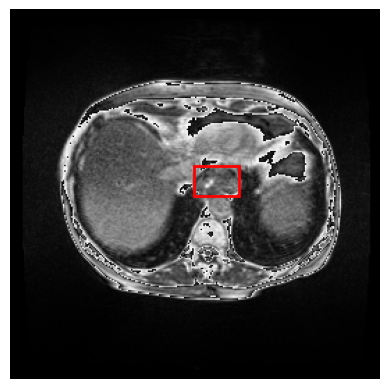

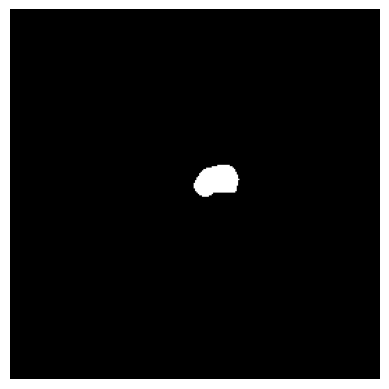

In [79]:
# Plot the image and plot the bounding box
import matplotlib.pyplot as plt
def plot_image_with_bbox(image, bbox):
    plt.imshow(image.permute(1, 2, 0))  # Convert to HWC format for plotting
    plt.axis('off')
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                           edgecolor='red', facecolor='none', linewidth=2))
    plt.show()
bbox = get_bbox_from_mask(mask)
plot_image_with_bbox(masks_image, bbox)

# Plot the mask
def plot_mask(mask):
    plt.imshow(mask.squeeze(), cmap='gray')  # Squeeze to remove channel dimension if present
    plt.axis('off')
    plt.show()
plot_mask(mask)



In [81]:
masks_path = '/home/miguel/GI/1.5 - Synthetic Data Generation/diffuse-gen/diffuse-gen/guided_diffusion/segmented-images-madison/masks'

In [80]:
bounding_boxes_json = {}

In [104]:
lengths = []
for mask_file in tqdm(os.listdir(masks_path)):
    mask_path = os.path.join(masks_path, mask_file)
    mask = io.read_image(mask_path, mode=io.ImageReadMode.UNCHANGED)
    bboxes = get_bbox_from_mask(mask)

    formatted_bboxes = []

    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox.tolist()
        formatted_bboxes.append({
            'label': 'stomach',
            'x_min': int(x_min),
            'y_min': int(y_min),
            'x_max': int(x_max),
            'y_max': int(y_max)
        })
    
    bounding_boxes_json[mask_file] = {
        'height': mask.shape[1],
        'width': mask.shape[2],
        'bbox': formatted_bboxes
    }
    lengths.append(len(formatted_bboxes))

100%|██████████| 8627/8627 [00:03<00:00, 2646.72it/s]


In [ ]:
# Export the file
import json
with open('bounding-boxes.json', 'w') as f:
    json.dump(bounding_boxes_json, f, indent=4)


In [101]:
list(bounding_boxes_json.values())[0]

{'height': 266,
 'width': 266,
 'bbox': [{'label': 'stomach',
   'x_min': 137,
   'y_min': 86,
   'x_max': 191,
   'y_max': 115}]}